## Clasificación de textos (Noticias)




### 1. Instalaciones

In [45]:
!pip install nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 2. Librerias

In [46]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

from pandas import DataFrame
import joblib


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

#import sklearn.externals

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


### 3. Carga de datos

https://github.com/jpposadas/FakeNewsCorpusSpanish/blob/master/train.xlsx

In [47]:
df = pd.read_excel('./datasets/05_NoticiasFakeTrain.xlsx', sheet_name='Hoja de datos')

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        676 non-null    int64 
 1   Category  676 non-null    object
 2   Topic     676 non-null    object
 3   Source    676 non-null    object
 4   Headline  676 non-null    object
 5   Text      676 non-null    object
 6   Link      676 non-null    object
dtypes: int64(1), object(6)
memory usage: 37.1+ KB


In [49]:
df.head()

,Id,Category,Topic,Source,Headline,Text,Link
0,1,Fake,Education,El Ruinaversal,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...","RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",http://www.elruinaversal.com/2017/06/10/rae-in...
1,2,Fake,Education,Hay noticia,"La palabra ""haiga"", aceptada por la RAE","La palabra ""haiga"", aceptada por la RAE La Rea...",https://haynoticia.es/la-palabra-haiga-aceptad...
2,3,Fake,Education,El Ruinaversal,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,http://www.elruinaversal.com/2018/05/06/yordi-...
3,4,True,Education,EL UNIVERSAL,UNAM capacitará a maestros para aprobar prueba...,UNAM capacitará a maestros para aprobar prueba...,http://www.eluniversal.com.mx/articulo/nacion/...
4,5,Fake,Education,Lamula,pretenden aprobar libros escolares con conteni...,Alerta: pretenden aprobar libros escolares con...,https://redaccion.lamula.pe/2018/06/19/memoria...


### 4. Preparación de datos

In [50]:
#Borrando columnas innecesarias
df.drop([ 'Id', 'Category', 'Source', 'Headline', 'Link'], axis='columns', inplace=True)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Topic   676 non-null    object
 1   Text    676 non-null    object
dtypes: object(2)
memory usage: 10.7+ KB


In [52]:
df.head()

,Topic,Text
0,Education,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR..."
1,Education,"La palabra ""haiga"", aceptada por la RAE La Rea..."
2,Education,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...
3,Education,UNAM capacitará a maestros para aprobar prueba...
4,Education,Alerta: pretenden aprobar libros escolares con...


In [53]:
#Checking for duplicates
df.loc[df.duplicated()]

,Topic,Text


In [54]:
df = df.drop_duplicates()

In [55]:
df.dropna(inplace=True)

In [56]:
#df = df.sample(n=500, replace=True, random_state = 123)

In [57]:
##Reiniciar el indice
#df.reset_index(drop=True, inplace=True)

In [58]:
df.shape

(676, 2)

### 5.  Descripción de categorías

In [59]:
df.groupby('Topic').Text.count().sort_values(ascending=False)

,Text
Topic,
Politics,226
Entertainment,103
Society,93
Sport,86
Science,62
Health,32
Economy,30
Security,29
Education,15


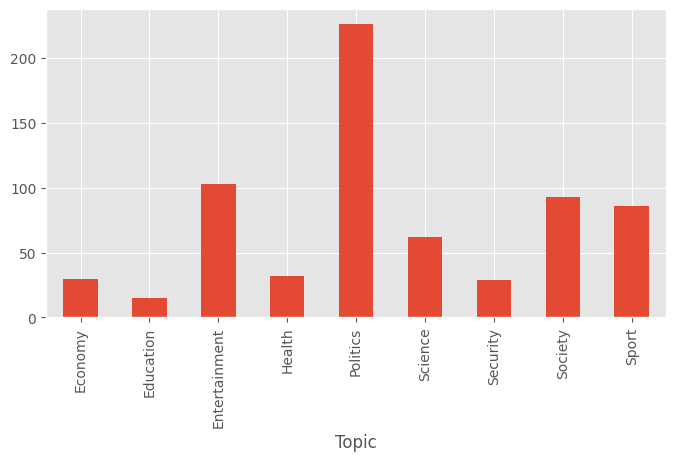

In [60]:
fig = plt.figure(figsize=(8,4))
df.groupby('Topic').Text.count().plot.bar(ylim=0)
plt.show()

### 5.  Preprocesamiento de texto y creación de bolsa de palabras

**Tf-idf** (del inglés Term frequency – Inverse document frequency), frecuencia de término – frecuencia inversa de documento (o sea, la frecuencia de ocurrencia del término en la colección de documentos), es una medida numérica que expresa cuán relevante es una palabra para un documento en una colección.

In [61]:
#Stopwords

spanish_stopwords = stopwords.words('spanish') + list(punctuation)

#stemming
stemmer = SnowballStemmer('spanish')

In [62]:
spanish_stopwords

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [63]:
#Creacion de bolsa de palabras

vectorizer = TfidfVectorizer(sublinear_tf=True       #transformación logarítmica suavizada en frcuencia de término.
                                                     # ayuda a reducir el impacto de las frecuencias de término altas
                                                     # y mejora el rendiemiento.
                             , min_df=5              #los terminos deben aparecer en almenos 5 documentos
                             , encoding='latin-1'
                             , ngram_range=(1, 3)
                             , stop_words=spanish_stopwords
                       )
features = vectorizer.fit_transform(df.Text)
labels = df['Topic']
features.shape

(676, 4682)

In [64]:
terms = vectorizer.get_feature_names_out()

doc_names = ['{:d}'.format(idx) for idx, _ in enumerate(features)]
dv = pd.DataFrame(data=features.toarray(), index=doc_names, columns=terms)
dv.head()

,abajo,abanderado,abanderado coalición,abandonar,abierta,abierto,abogado,abogados,abordar,abre,...,último,últimos,últimos años,últimos días,últimos meses,últimos number,única,únicamente,único,útil
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.060757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.057784,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# Dataset con bolsa de palabras
result = pd.concat([df[['Topic']].reset_index(drop=True), dv.reset_index(drop=True)], axis=1)

result[1:40]

,Topic,abajo,abanderado,abanderado coalición,abandonar,abierta,abierto,abogado,abogados,abordar,...,último,últimos,últimos años,últimos días,últimos meses,últimos number,única,únicamente,único,útil
1,Education,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,Education,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,Education,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,Education,0.000000,0.0,0.0,0.0,0.0,0.057784,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,Education,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
6,Education,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.058553,0.000000
7,Education,0.000000,0.0,0.0,0.0,0.0,0.104846,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.079035,0.000000
8,Education,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.033373,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
9,Education,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.061764,0.000000,0.000000,0.000000
10,Education,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.034673,0.000000,0.00000,0.0,0.000000,0.000000,0.050427,0.000000,0.000000


#### Palabras relevantes por cada noticia

In [66]:
# se selecciona un regitro: para este caso el de index=4 y lo convierte en un arreglo NumPy.
sr = result[4:5].to_numpy()

# Crea una Serie 'sr' a partir del primer elemento del arreglo 'sr'.
sr = pd.Series(sr[[0][0]])

# Elimina el primer elemento de la Serie 'sr' (y almacena el resultado en 'sr2'). Se elimina el título de las columnas
sr2 = sr.drop(sr.index[0])

# Obtiene una lista de nombres de columnas en 'result' que tienen el tipo de dato 'float64'.
index_ = result.select_dtypes(include=["float64"]).columns.tolist()

# Establece los nombres de las columnas de 'sr2' según la lista de nombres de columnas obtenida anteriormente.
sr2.index = index_

# Invierte el orden de clasificación de 'sr2', obtiene los índices que ordenarían la Serie.
r = (-sr2).argsort()

# Imprime las 20 primeras palabras (o columnas) en función del orden especificado por 'r'.
print(sr2[r][:20])

textos               0.165565
derechos humanos     0.158906
contenidos           0.142617
congreso             0.141485
humanos               0.14135
educación            0.137513
armado               0.136424
interno              0.136424
terror               0.133154
derechos             0.128321
conflicto            0.121267
derecho              0.120159
talleres             0.113111
promover             0.110066
memoria              0.110066
perú                 0.110066
responsabilidades    0.110066
criterios            0.110066
convenio             0.105101
carácter             0.105101
dtype: object


In [67]:
#Palabras relevantes por cada noticia

#Seleccionamos un regitro: para este caso el de index=4
sr=result[4:5].to_numpy()

sr=pd.Series(sr[[0][0]])
sr2 = sr.drop(sr.index[0])
index_=result.select_dtypes(include = ["float64"]).columns.tolist()

# set the index
sr2.index = index_
r=(-sr2).argsort()[:4682]
print(sr2[r][:20])

textos               0.165565
derechos humanos     0.158906
contenidos           0.142617
congreso             0.141485
humanos               0.14135
educación            0.137513
armado               0.136424
interno              0.136424
terror               0.133154
derechos             0.128321
conflicto            0.121267
derecho              0.120159
talleres             0.113111
promover             0.110066
memoria              0.110066
perú                 0.110066
responsabilidades    0.110066
criterios            0.110066
convenio             0.105101
carácter             0.105101
dtype: object


### 7. Identificación de modelos

In [68]:
#Identificación de los mejores modelos:


models = [
    RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=21),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=1)
]

#Cross-validation: 10-folds
CV = 10

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


In [69]:
cv_df[:][0:60]

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.514706
1,RandomForestClassifier,1,0.632353
2,RandomForestClassifier,2,0.676471
3,RandomForestClassifier,3,0.661765
4,RandomForestClassifier,4,0.617647
5,RandomForestClassifier,5,0.529412
6,RandomForestClassifier,6,0.611940
7,RandomForestClassifier,7,0.641791
8,RandomForestClassifier,8,0.582090
9,RandomForestClassifier,9,0.597015


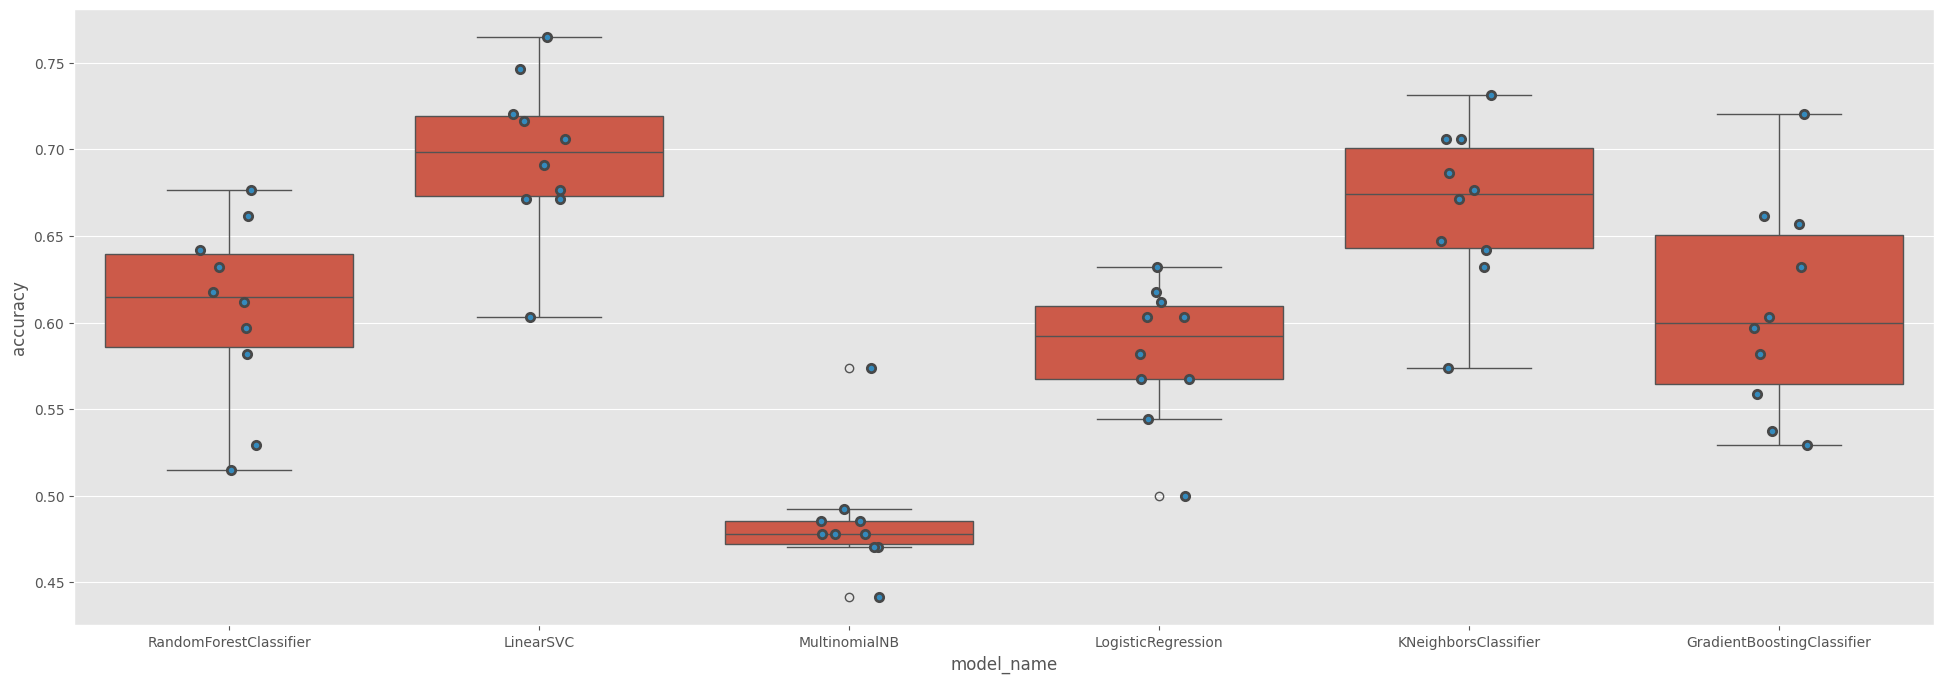

In [70]:
# Gráfica de accuracy de los modelos

figsize=(24,8)

plt.rcParams['figure.figsize'] = figsize

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=6, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [71]:
# Accuracy de los modelos

cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False)

,accuracy
model_name,
LinearSVC,0.696773
KNeighborsClassifier,0.667252
GradientBoostingClassifier,0.607902
RandomForestClassifier,0.606519
LogisticRegression,0.582836
MultinomialNB,0.485184


Se eligen los dos modelos

### 8. Creación del modelo

In [72]:

model01 = LinearSVC()
model02 = KNeighborsClassifier()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.1, random_state=0)
model01.fit(X_train, y_train)
model02.fit(X_train, y_train)

KNeighborsClassifier()

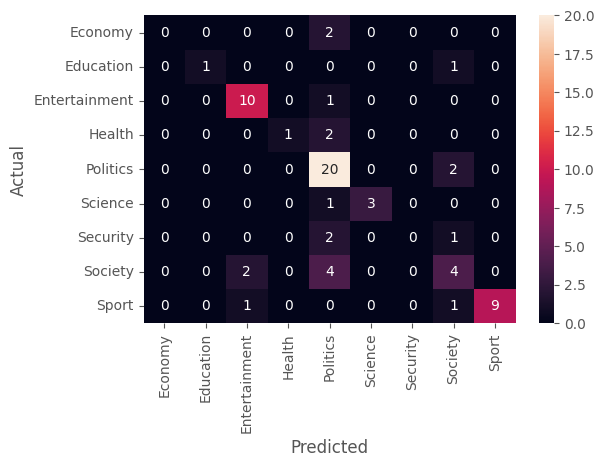

               precision    recall  f1-score   support

      Economy       0.00      0.00      0.00         2
    Education       1.00      0.50      0.67         2
Entertainment       0.77      0.91      0.83        11
       Health       1.00      0.33      0.50         3
     Politics       0.62      0.91      0.74        22
      Science       1.00      0.75      0.86         4
     Security       0.00      0.00      0.00         3
      Society       0.44      0.40      0.42        10
        Sport       1.00      0.82      0.90        11

     accuracy                           0.71        68
    macro avg       0.65      0.51      0.55        68
 weighted avg       0.69      0.71      0.67        68



In [73]:
#Matriz de confusión

y_pred = model01.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=df['Topic'].sort_values().unique()
            , yticklabels=df['Topic'].sort_values().unique()
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test, y_pred))

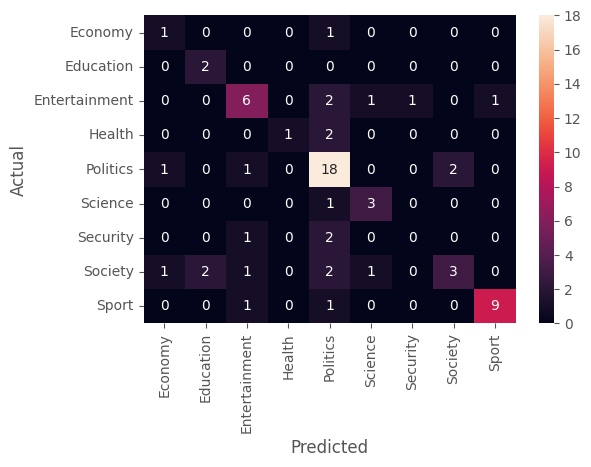

               precision    recall  f1-score   support

      Economy       0.33      0.50      0.40         2
    Education       0.50      1.00      0.67         2
Entertainment       0.60      0.55      0.57        11
       Health       1.00      0.33      0.50         3
     Politics       0.62      0.82      0.71        22
      Science       0.60      0.75      0.67         4
     Security       0.00      0.00      0.00         3
      Society       0.60      0.30      0.40        10
        Sport       0.90      0.82      0.86        11

     accuracy                           0.63        68
    macro avg       0.57      0.56      0.53        68
 weighted avg       0.64      0.63      0.61        68



In [74]:
#Matriz de confusión

y_pred = model02.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=df['Topic'].sort_values().unique()
            , yticklabels=df['Topic'].sort_values().unique()
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(metrics.classification_report(y_test, y_pred))

In [75]:
#Se guarda el modelo de SVM
joblib.dump(model01, './modelos/texto/modelTextSVC.pkl')

['./modelos/texto/modelTextSVC.pkl']

In [76]:
#Se guarda el modelo de Regresión KNN
joblib.dump(model02, './modelos/texto/modelTextKNN.pkl')

['./modelos/texto/modelTextKNN.pkl']

### 9. Producción

In [77]:
model01C = joblib.load('./modelos/texto/modelTextSVC.pkl') # Carga del modelo.
model02C =  joblib.load('./modelos/texto/modelTextKNN.pkl') # Carga del modelo.

In [78]:
def queryCategory(query):

    texts = [query]
    text_features = vectorizer.transform(texts)
    p=text_features.nonzero()[0]

    if p.size== 0:
        predictions =  []
    else:
        predictionsId = model01C.predict(text_features)
        predictionsId = np.append(predictionsId, model02C.predict(text_features))


        predictions = [predictionsId]

    return predictions

In [79]:
queryCategory("futbol CANDIDATO selección FUTBOL CANDIDATO")

[array(['Politics', 'Sport'], dtype=object)]

In [80]:
queryCategory("si bien el documento muestra una propuesta, sería interesante mostrar aplicaciones.")

[array(['Science', 'Science'], dtype=object)]

In [81]:
queryCategory("televisión fashion")

[array(['Entertainment', 'Politics'], dtype=object)]